# Predicting prices of players from the top 5 football leagues

## Summary

## Step 1: Librairies import

In [1]:
# Pandas
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns',None)

# Beautiful Soup for Web scrapping
import requests
from bs4 import BeautifulSoup

# Seaborn for data visualization
import seaborn as sns
sns.set_theme()

# Numpy and SKLearn for modelization
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import TheilSenRegressor
from sklearn.datasets import make_regression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import svm

# XGBoost for modelization
!pip install xgboost
from xgboost import XGBRegressor

# Matplotlib for data visulization
import matplotlib.pyplot as plt

# Pickle for API
import pickle

import random

## Step 2: Data visualization

### Dataset overview

In [2]:
DATA = pd.read_csv("dataset_football_cleaned.csv")

# Select the top 5 leagues

selected_leagues = ['PremierLeague','SerieA','Bundesliga','Ligue1','LaLiga']
DATA = DATA[DATA.league.isin(selected_leagues)]

# Delete "fake" Premier League and BundesLiga

# 1. Egyptian premier league players are after the index 4920
DATA = DATA[DATA.index<4920]

# 2. Austrian bundesliga players are between the indexes 2702 and 2871 included
before_2072 = DATA[DATA.index<2702]
after_2871 = DATA[DATA.index>2871]
DATA = pd.concat([before_2072,after_2871],axis=0)
# Not very elegant but working

DATA

,name,first_name,age,nation,league,team,goals_selection,selections_nation,position,price,end_contract,goal_champ,assist_champ,own_goal_champ,sub_on_champ,sub_out_champ,yellow_card_champ,second_yellow_card_champ,red_card_champ,penalty_goal_champ,conceded_goal_champ,clean_sheet_champ,goal_cup,assist_cup,own_goal_cup,sub_on_cup,sub_out_cup,yellow_card_cup,second_yellow_card_cup,red_card_cup,penalty_goal_cup,conceded_goal_cup,clean_sheet_cup,goal_continent,assist_continent,own_goal_continent,sub_on_continent,sub_out_continent,yellow_card_continent,second_yellow_card_continent,red_card_continent,penalty_goal_continent,conceded_goal_continent,clean_sheet_continent
0,Etheridge,Neil,28,Philippines,PremierLeague,Cardiff,0,60,Goalkeeper,4000000.0,3.0,0.0,0.0,0.0,0.0,1.0,9.0,0.0,0.0,237.0,59.0,0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,22.0,3.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0,0
42,Hoilett,Junior,28,Canada,PremierLeague,Cardiff,3,20,LeftWinger,4500000.0,3.0,49.0,45.0,0.0,91.0,127.0,30.0,0.0,0.0,2.0,0.0,0,5.0,4.0,0.0,7.0,6.0,2.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
43,Mendez0Laing,Nathaniel,26,England,PremierLeague,Cardiff,0,0,RightWinger,2500000.0,3.0,33.0,32.0,0.0,104.0,79.0,7.0,0.0,0.0,0.0,0.0,0,8.0,3.0,0.0,19.0,12.0,0.0,0.0,0.0,1.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
44,Murphy,Josh,23,England,PremierLeague,Cardiff,1,3,LeftWinger,8000000.0,4.0,38.0,31.0,0.0,71.0,59.0,18.0,0.0,0.0,1.0,0.0,0,16.0,5.0,0.0,6.0,10.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
45,Reid,Bobby,25,England,PremierLeague,Cardiff,0,0,AttackingMidfield,10000000.0,4.0,31.0,26.0,0.0,48.0,61.0,22.0,0.0,0.0,3.0,0.0,0,3.0,5.0,0.0,7.0,7.0,1.0,0.0,0.0,1.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4912,Shaqiri,Xherdan,27,Switzerland,PremierLeague,Liverpool,22,80,RightWinger,25000000.0,5.0,67.0,59.0,0.0,79.0,126.0,38.0,0.0,0.0,5.0,0.0,0,1.0,0.0,0.0,5.0,3.0,3.0,0.0,0.0,0.0,0,0,4.0,7.0,0.0,19.0,9.0,3.0,0.0,1.0,0.0,0,0
4913,Markovic,Lazar,24,Serbia,PremierLeague,Fulham,3,22,RightWinger,5000000.0,1.0,26.0,24.0,0.0,41.0,71.0,19.0,0.0,0.0,0.0,0.0,0,4.0,1.0,0.0,12.0,12.0,2.0,0.0,0.0,0.0,0,0,2.0,2.0,0.0,13.0,13.0,0.0,0.0,2.0,0.0,0,0
4914,Seri,JeanMichaël,27,Coted'Ivoire,PremierLeague,Fulham,2,22,CentralMidfield,30000000.0,4.0,18.0,33.0,0.0,12.0,58.0,34.0,1.0,0.0,4.0,0.0,0,1.0,2.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,0,0,0.0,2.0,0.0,2.0,8.0,3.0,0.0,0.0,0.0,0,0
4915,Shelvey,Jonjo,26,England,PremierLeague,Newcastle,0,6,CentralMidfield,15000000.0,3.0,36.0,42.0,1.0,61.0,66.0,48.0,2.0,3.0,3.0,0.0,0,3.0,7.0,0.0,11.0,6.0,3.0,0.0,0.0,0.0,0,0,4.0,2.0,0.0,6.0,2.0,3.0,0.0,0.0,0.0,0,0


In [3]:
DATA.describe()

,age,goals_selection,selections_nation,price,end_contract,goal_champ,assist_champ,own_goal_champ,sub_on_champ,sub_out_champ,yellow_card_champ,second_yellow_card_champ,red_card_champ,penalty_goal_champ,conceded_goal_champ,clean_sheet_champ,goal_cup,assist_cup,own_goal_cup,sub_on_cup,sub_out_cup,yellow_card_cup,second_yellow_card_cup,red_card_cup,penalty_goal_cup,conceded_goal_cup,clean_sheet_cup,goal_continent,assist_continent,own_goal_continent,sub_on_continent,sub_out_continent,yellow_card_continent,second_yellow_card_continent,red_card_continent,penalty_goal_continent,conceded_goal_continent,clean_sheet_continent
count,1312.000000,1312.000000,1312.000000,1.312000e+03,1297.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.0,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.0,1312.0,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.0,1312.0
mean,25.995427,1.887195,15.163110,1.133218e+07,2.812645,22.663872,18.853659,0.205030,33.150915,43.851372,25.426829,0.688262,0.731707,52.354421,13.733994,0.0,1.882622,1.564787,0.031250,3.047256,3.244665,1.570884,0.043445,3.054878,0.974085,0.0,0.0,1.737043,1.586128,0.028201,2.795732,3.139482,1.620427,2.929116,0.814787,0.129573,0.0,0.0
std,4.436687,5.629232,24.062452,1.941081e+07,1.400913,30.069647,22.949550,0.509144,28.116600,39.571349,22.858584,1.138568,1.038379,119.305287,34.309514,0.0,3.818731,3.110781,0.186744,3.971972,4.361301,2.503302,0.203935,8.674205,2.704506,0.0,0.0,5.732818,3.908397,0.191259,4.493682,5.844507,3.149101,11.908320,3.759351,0.711662,0.0,0.0
min,17.000000,0.000000,0.000000,5.000000e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,23.000000,0.000000,1.000000,1.500000e+06,2.000000,1.000000,0.000000,0.000000,6.000000,7.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,26.000000,0.000000,5.000000,4.500000e+06,3.000000,15.000000,12.000000,0.000000,30.000000,35.000000,19.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
75%,29.000000,1.000000,18.000000,1.300000e+07,4.000000,32.000000,28.000000,0.000000,50.000000,67.000000,35.000000,1.000000,1.000000,9.250000,0.000000,0.0,2.000000,2.000000,0.000000,5.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,1.000000,0.000000,4.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.0
max,41.000000,85.000000,176.000000,2.000000e+08,8.000000,423.000000,174.000000,4.000000,216.000000,222.000000,141.000000,9.000000,8.000000,791.000000,333.000000,0.0,63.000000,39.000000,2.000000,28.000000,35.000000,19.000000,1.000000,60.000000,26.000000,0.0,0.0,121.000000,44.000000,3.000000,29.000000,45.000000,25.000000,120.000000,55.000000,15.000000,0.0,0.0


<AxesSubplot:xlabel='price', ylabel='position'>

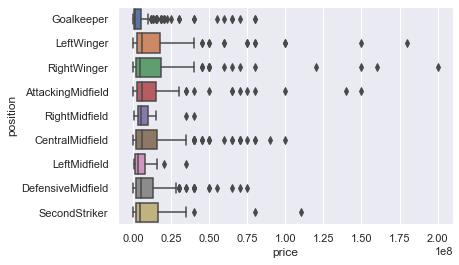

In [4]:
# Box Plotting price against the different positions
sns.boxplot(x="price", y="position", data=DATA)

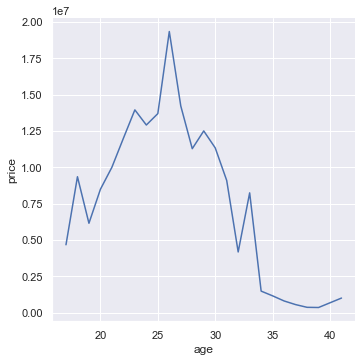

In [5]:
# Curve of the price against the age 
means = DATA.groupby('age', as_index=False)['price'].mean()
sns.relplot(x="age",y="price",kind="line",data=means)

<AxesSubplot:xlabel='end_contract', ylabel='price'>

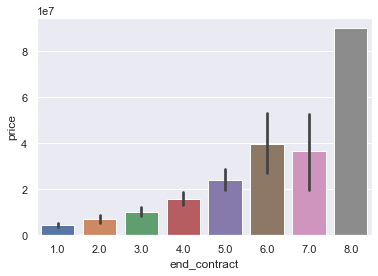

In [6]:
sns.barplot(x="end_contract",y="price",data=DATA)

<AxesSubplot:>

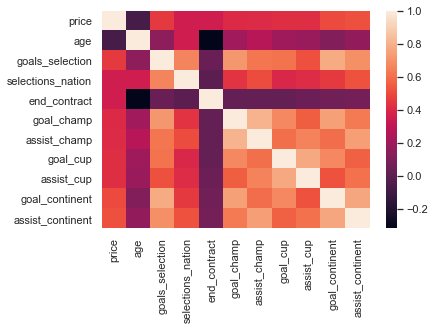

In [7]:
# Correlation matrix with the variables that seems to explains the best a player's price
DATA_corr = DATA[["price","age","goals_selection","selections_nation","end_contract","goal_champ",
                "assist_champ","goal_cup","assist_cup","goal_continent","assist_continent"]]
corr = DATA_corr.corr()
sns.heatmap(corr)

## Step 3: Data pre-processing

### Issue 1: Get dummies for positions

In [8]:
# Necessary to apply regression algorithms
dum_position = pd.get_dummies(DATA['position'], columns=["position"])
DATA = DATA.drop(['position'],axis=1)
DATA = pd.concat([DATA,dum_position],axis=1)

### Issue 2: Delete goalkeepers and related variables

In [9]:
# Delete goalkeepers rows
DATA = DATA[DATA.Goalkeeper != 1]

# Delete columns related to them
DATA.drop(["Goalkeeper","conceded_goal_champ","clean_sheet_champ","conceded_goal_cup","clean_sheet_cup",
           "conceded_goal_continent","clean_sheet_continent"],axis=1,inplace=True)

### Issue 3: Sum yellow cards from championship, cup and continent (same for red cards)

In [10]:
# Create two new columns with the sum of yellow and red cards 
yellow_cards = DATA.yellow_card_champ + DATA.yellow_card_continent + DATA.yellow_card_cup
red_cards = DATA.red_card_champ + DATA.red_card_continent + DATA.red_card_cup 
cards = pd.DataFrame({"yellows_cards":yellow_cards,"red_cards":red_cards})

# Drop the old columns 
DATA.drop(["yellow_card_champ","yellow_card_continent","yellow_card_cup",
           "red_card_champ","red_card_continent","red_card_cup",
           "second_yellow_card_cup","second_yellow_card_champ","second_yellow_card_continent"],axis=1,inplace=True)

# Concat the two new columns 
DATA = pd.concat([DATA,cards],axis=1)

### Issue 4: Take out the sub on/out columns

In [11]:
DATA.drop(["sub_on_champ","sub_out_champ",
           "sub_on_cup","sub_out_cup",
           "sub_on_continent","sub_out_continent"],axis=1,inplace=True)

### Issue 5: Take out the identifiers

In [12]:
DATA.drop(["name","first_name"],axis=1,inplace=True)

### Issue 6: Team, league and nation variables valuation

#### 1. Team valuation using UEFA index

In [13]:
# Web scrapping on a website displaying the UEFA index on the last 5 years in English
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

page = "https://kassiesa.net/uefa/data/method5/trank2020.html"
pageTree = requests.get(page, headers=headers)
pageSoup = BeautifulSoup(pageTree.content, 'html.parser')

# Finding the values we are looking for
teams = pageSoup.find_all("td",{'align': 'left'})
scores = pageSoup.find_all("th",{'class':'lgray'})

# Creating the dataframe with the teams and their coefficients 
teams_List = []
scores_List = []
for i in range(400):
    teams_List.append(teams[i+1].text)
    scores_List.append(scores[i].text)
    
UEFA_club_coefficients = pd.DataFrame({"Team":teams_List,"Coefficient":scores_List})
UEFA_club_coefficients

,Team,Coefficient
0,Bayern München,136.000
1,Real Madrid,134.000
2,FC Barcelona,128.000
3,Atlético Madrid,127.000
4,Juventus,117.000
...,...,...
395,Ballymena United,1.250
396,Zeta Golubovci,1.250
397,Breidablik,1.250
398,Coleraine,1.250


#### 2. League valuation using UEFA index

In [14]:
# No web scrapping needed here because we are only considering the top 5 leagues and it could be done manually
leagues = ['PremierLeague','SerieA','Bundesliga','Ligue1','LaLiga']
coefficients = [90.462,70.653,74.784,59.248,102.283]
UEFA_league_coefficients = pd.DataFrame({"League":leagues,"Coefficient":coefficients})
UEFA_league_coefficients.sort_values(by=["Coefficient"],inplace=True,ascending=False)
UEFA_league_coefficients

,League,Coefficient
4,LaLiga,102.283
0,PremierLeague,90.462
2,Bundesliga,74.784
1,SerieA,70.653
3,Ligue1,59.248


#### 3. Nation valuation using FIFA index

In [15]:
# We scrapping on the official FIFA website to get the actual nations ranking 
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

page = "https://www.fifa.com/fifa-world-ranking/ranking-table/men/"
pageTree = requests.get(page, headers=headers)
pageSoup = BeautifulSoup(pageTree.content, 'html.parser')

# Finding the values we are looking for
nations = pageSoup.find_all("div", {"class": "fi-t__n"})
points = pageSoup.find_all("td", {"class": "fi-table__td fi-table__points"})

# Creating the dataframe with the  and their coefficients 
nation_list=[]
points_list=[]
for i in range(len(nations)):
    nation = nations[i].text[1:]
    nation = nation[:nation.index('\n')] 
    nation_list.append(nation)
    points_list.append(points[i].text)
    
Nations_ranking = pd.DataFrame({"Nations" : nation_list, "Points":points_list})
Nations_ranking

,Nations,Points
0,Belgium,1780
1,France,1755
2,Brazil,1743
3,England,1670
4,Portugal,1662
...,...,...
205,Sri Lanka,853
206,US Virgin Islands,844
207,British Virgin Islands,842
208,Anguilla,821


#### 4. Replacing names

In [16]:
# Names need to be corrected because the nomenclature is different between web sources
# No other way to do it rather than manually

# For UEFA teams index 
DATA.replace({"BayernMunich":"BayernMünchen"}, inplace = True)
DATA.replace({"E.Frankfurt":"EintrachtFrankfurt"}, inplace = True)
DATA.replace({"Monaco":"ASMonaco"}, inplace = True)
DATA.replace({"Bor.Dortmund ":"BorussiaDortmund"}, inplace = True)
DATA.replace({"Bor.M'gladbach":"BorussiaMönchengladbach"}, inplace = True)
DATA.replace({"Athletic ":"AthleticBilbao"}, inplace = True)
DATA.replace({"1.FSVMainz05":"FSVMainz05"}, inplace = True)
DATA.replace({"FCSchalke04":"Schalke04"}, inplace = True)
DATA.replace({"Leicester":"LeicesterCity"}, inplace = True)
DATA.replace({"Burnley ":"BurnleyFC"}, inplace = True)
DATA.replace({"Marseille":"OlympiqueMarseille"}, inplace = True)
DATA.replace({"ParisSG":"ParisSaint-Germain"}, inplace = True)
DATA.replace({"Inter ":"Internazionale"}, inplace = True)
DATA.replace({"SevillaFC":"Sevilla"}, inplace = True)
DATA.replace({"R.Strasbourg":"RCStrasbourg"}, inplace = True)
DATA.replace({"G.Bordeaux":"GirondinsBordeaux"}, inplace = True)
DATA.replace({"ManUtd ":"ManchesterUnited"}, inplace = True)
DATA.replace({"ManCity":"ManchesterCity"}, inplace = True)
DATA.replace({"RapidVienna  ":"RapidWien"}, inplace = True)
DATA.replace({"SSCNapoli":"Napoli"}, inplace = True)
DATA.replace({"Bay.Leverkusen":"BayerLeverkusen"}, inplace = True)
DATA.replace({"LOSCLille ":"LilleOSC"}, inplace = True)
DATA.replace({"TSGHoffenheim":"1899Hoffenheim"}, inplace = True)
DATA.replace({"Saint0Étienne ":"ASSaint-Étienne"}, inplace = True)
DATA.replace({"Spurs":"TottenhamHotspur"}, inplace = True)
DATA.replace({"WestHam ":"WestHamUnited"}, inplace = True)
DATA.replace({"Southampton ":"SouthamptonFC"}, inplace = True)
DATA.replace({"Wolves ":"WolverhamptonWanderers"}, inplace = True)

# 2. For FIFA nations index
DATA.replace({"Coted'Ivoire":"Côte d'Ivoire"}, inplace = True)
DATA.replace({"UnitedStates":"USA"}, inplace = True)
DATA.replace({"CzechRepublic":"Czech Republic"}, inplace = True)
DATA.replace({"DRCongo":"Congo DR"}, inplace = True)
DATA.replace({"Bosnia0Herzegovina":"Bosnia and Herzegovina"}, inplace = True)
DATA.replace({"Korea,South":"Korea Republic"}, inplace = True)
DATA.replace({"SouthAfrica":"South Africa"}, inplace = True)
DATA.replace({"BurkinaFaso":"Burkina Faso"}, inplace = True)
DATA.replace({"China":"China PR"}, inplace = True)
DATA.replace({"Macedonia":"North Macedonia"}, inplace = True)
DATA.replace({"Iran":"IR Iran"}, inplace = True)
DATA.replace({"Ireland":"Republic of Ireland"}, inplace = True)
DATA.replace({"Curacao":"Curaçao"}, inplace = True)
DATA.replace({"EquatorialGuinea":"Equatorial Guinea"}, inplace = True)
DATA.replace({"Guinea0Bissau":"Guinea-Bissau"}, inplace = True)
DATA.replace({"TrinidadandTobago":"Trinidad and Tobago"}, inplace = True)
DATA.replace({"CentralAfricanRepublic":"Central African Republic"}, inplace = True)
DATA.replace({"SierraLeone":"Sierra Leone"}, inplace = True)

#### 5. Replacing the strings in DATA by the corresponding value from the UEFA/FIFA indexes

In [17]:
# For clubs (maybe long ~ 1 min)
for i in range(120):
    current_team = UEFA_club_coefficients.iloc[i][0].replace(" ","")
    coeff = float(UEFA_club_coefficients.iloc[i][1])
    for j in range(len(DATA.team)):
        team = DATA.iloc[j][3]
        if team == current_team:
            DATA.replace({team:coeff}, inplace = True)
 
#
# if the club is not found in the UEFA index (meaning is has not been performing in continental
# competition within the last 5 years), his score equals to 0 
for i in range(len(DATA.team)):
    if type(DATA.iloc[i][3]) == str:
        DATA.replace({DATA.iloc[i][3]:0}, inplace = True)

In [18]:
# For leagues
for i in range(len(UEFA_league_coefficients.League)):
    current_league = UEFA_league_coefficients.iloc[i][0]
    coeff = float(UEFA_league_coefficients.iloc[i][1])
    for j in range(len(DATA.team)):
        league = DATA.iloc[j][2]
        if league == current_league:
            DATA.replace({league:coeff}, inplace = True)

In [19]:
# For nations (maybe long ~ 1 min)
for i in range(len(Nations_ranking.Nations)):
    current_nation = Nations_ranking.iloc[i][0]
    coeff = float(Nations_ranking.iloc[i][1])
    for j in range(len(DATA.team)):
        nation = DATA.iloc[j][1]
        if nation == current_nation:
            DATA.replace({nation:coeff}, inplace = True)

In [20]:
DATA.dropna(axis=0,how="any") # Deleting NaN
DATA.drop(DATA.loc[DATA['nation']=="Guadeloupe"].index, inplace=True)
DATA["nation"] = DATA["nation"].astype(float) # Converting object type to float for regression

In [21]:
DATA.drop(DATA.loc[DATA['end_contract'].isnull() == True].index, inplace=True) # Deleting NaN

In [22]:
# Data overview after pre-processing
DATA
# We now only have quantitative variables and we are able to star the regression

,age,nation,league,team,goals_selection,selections_nation,price,end_contract,goal_champ,assist_champ,own_goal_champ,penalty_goal_champ,goal_cup,assist_cup,own_goal_cup,penalty_goal_cup,goal_continent,assist_continent,own_goal_continent,penalty_goal_continent,AttackingMidfield,CentralMidfield,DefensiveMidfield,LeftMidfield,LeftWinger,RightMidfield,RightWinger,SecondStriker,yellows_cards,red_cards
42,28,1332.0,90.462,0.0,3,20,4500000.0,3.0,49.0,45.0,0.0,2.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,32.0,0.0
43,26,1670.0,90.462,0.0,0,0,2500000.0,3.0,33.0,32.0,0.0,0.0,8.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,7.0,0.0
44,23,1670.0,90.462,0.0,1,3,8000000.0,4.0,38.0,31.0,0.0,1.0,16.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,19.0,0.0
45,25,1670.0,90.462,0.0,0,0,10000000.0,4.0,31.0,26.0,0.0,3.0,3.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,23.0,0.0
46,25,1670.0,90.462,0.0,0,0,500000.0,1.0,7.0,11.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,11.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4912,27,1593.0,90.462,99.0,22,80,25000000.0,5.0,67.0,59.0,0.0,5.0,1.0,0.0,0.0,0.0,4.0,7.0,0.0,0.0,0,0,0,0,0,0,1,0,44.0,1.0
4913,24,1495.0,90.462,0.0,3,22,5000000.0,1.0,26.0,24.0,0.0,0.0,4.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0,0,0,0,0,0,1,0,21.0,2.0
4914,27,1384.0,90.462,0.0,2,22,30000000.0,4.0,18.0,33.0,0.0,4.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0,1,0,0,0,0,0,0,39.0,0.0
4915,26,1670.0,90.462,0.0,0,6,15000000.0,3.0,36.0,42.0,1.0,3.0,3.0,7.0,0.0,0.0,4.0,2.0,0.0,0.0,0,1,0,0,0,0,0,0,54.0,3.0


## Step 4: Modelization

In [23]:
# Evaluation functions

# Since we study numbers with high magnitude we use the RMSE 
def display_rmse(pred):
    mse=mean_squared_error(Y_test, pred)
    print("RMSE : {}".format(np.sqrt(mse)))
    
def rmse(pred):
    rmse=np.sqrt(mean_squared_error(Y_test, pred))
    return rmse
    
# This function gives the price prediction for a random player from the dataset 
def compare_random(pred):
    random_number = random.randint(0,Y_test.__len__())
    print("Example of prediction\nPrediction : {}  True Value : {} ".format(pred[random_number],Y_test.values[random_number]))

In [24]:
# Seperating target from the rest
Y = DATA["price"]
X = DATA.loc[:, DATA.columns != 'price']
# Shuffle
DATA = DATA.sample(frac=1).reset_index(drop=True)

In [25]:
# Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=123)

### Linear model

In [26]:
lin_reg = LinearRegression().fit(X_train, Y_train)
Y_pred_lin = lin_reg.predict(X_test)

display_rmse(Y_pred_lin)
compare_random(Y_pred_lin)

RMSE : 17666979.651735693
Example of prediction
Prediction : 34660387.36264514  True Value : 65000000.0 


### Theil-Sen Estimator

In [27]:
TS_reg = TheilSenRegressor().fit(X_train, Y_train)
Y_pred_TS = TS_reg.predict(X_test)

display_rmse(Y_pred_TS)
compare_random(Y_pred_TS)

RMSE : 17446327.09758916
Example of prediction
Prediction : 25553920.124166556  True Value : 6000000.0 


### Support vector regression

#### Radial basis function kernel

In [28]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
Y_pred_svr_rbf = svr_rbf.fit(X_train,Y_train).predict(X_test)
display_rmse(Y_pred_svr_rbf)
compare_random(Y_pred_svr_rbf)

RMSE : 25574064.41958955
Example of prediction
Prediction : 5000038.579834821  True Value : 15000000.0 


#### Linear kernel

In [29]:
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
Y_pred_svr_lin = svr_lin.fit(X_train,Y_train).predict(X_test)
display_rmse(Y_pred_svr_lin)
compare_random(Y_pred_svr_lin)

RMSE : 19909454.431053042
Example of prediction
Prediction : 5319427.880231306  True Value : 10000000.0 


### XGBOOST

In [30]:
xgb = XGBRegressor()
xgb.fit(X_train,Y_train)
Y_pred_xgb = xgb.predict(X_test)
display_rmse(Y_pred_xgb)
compare_random(Y_pred_xgb)

RMSE : 14600835.623787127
Example of prediction
Prediction : 65353096.0  True Value : 60000000.0 


### Decision tree

In [31]:
tree = DecisionTreeRegressor(max_depth=6)
tree.fit(X_train,Y_train)
Y_pred_tree = tree.predict(X_test)
display_rmse(Y_pred_tree)
compare_random(Y_pred_tree)

RMSE : 18162882.469658997
Example of prediction
Prediction : 6049586.776859504  True Value : 400000.0 


### Random forests

In [32]:
# With 4 trees and 6 of depth each
rf_4_6 = RandomForestRegressor(n_estimators=4, max_depth=6)
rf_4_6.fit(X_train, Y_train)
Y_pred_rf_4_6 = rf_4_6.predict(X_test)
display_rmse(Y_pred_rf_4_6)
compare_random(Y_pred_rf_4_6)

RMSE : 18302132.339725837
Example of prediction
Prediction : 9821921.278126635  True Value : 10000000.0 


In [33]:
# With 10 trees and 6 of depth each
rf_10_6 = RandomForestRegressor(n_estimators=10, max_depth=6)
rf_10_6.fit(X_train, Y_train)
Y_pred_rf_10_6 = rf_10_6.predict(X_test)
display_rmse(Y_pred_rf_10_6)
compare_random(Y_pred_rf_10_6)

RMSE : 14829095.063591158
Example of prediction
Prediction : 32035185.185185183  True Value : 7000000.0 


### Which model is the best ? 

In [34]:
models = ["Linear","Theil-Sen","SVR RBF","SVR Linear","XGBOOST","Decision Tree","RF 4 trees","RF 10 trees"]
RMSE = [rmse(Y_pred_lin),rmse(Y_pred_TS),rmse(Y_pred_svr_rbf),rmse(Y_pred_svr_lin),
        rmse(Y_pred_tree),rmse(Y_pred_lin),rmse(Y_pred_rf_4_6),rmse(Y_pred_rf_10_6)]
evaluation = dict(zip(models, RMSE))
eval_pd = pd.DataFrame.from_dict(evaluation, orient="index").sort_values(by=0,ascending=True)
eval_pd.columns = ["RMSE"]
eval_pd

,RMSE
RF 10 trees,1.482910e+07
Theil-Sen,1.744633e+07
Linear,1.766698e+07
Decision Tree,1.766698e+07
XGBOOST,1.816288e+07
RF 4 trees,1.830213e+07
SVR Linear,1.990945e+07
SVR RBF,2.557406e+07


### Grid search

In [35]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100]}
svr = svm.SVR()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, Y_train)
GridSearchCV(estimator=SVR(),
             param_grid={'C': [1, 10,100], 'kernel': ('linear', 'rbf')})
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

## Step 5: Code for API 

In [36]:
pickle.dump(rf_10_6, open('Predict_price.pkl', 'wb'))
predict_price = pickle.load(open('Predict_price.pkl','rb'))